# 2차 CPT (Continual Pre-Training) for LLM
- 금융언어모델 학습
- 고급 금융지식 및 추론능력 함양이 목적

In [1]:
# set random seed
import numpy as np
import random
import os

def seed_everything(seed: int = 777):
    random.seed(seed)
    np.random.seed(seed)
    if seed is not None:
        os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(777)

In [2]:
hf_token = 'hf_****'

from unsloth import FastLanguageModel
import torch
max_seq_length = 1024
dtype = None # None으로 지정할 경우 해당 컴퓨팅 유닛에 알맞은 dtype으로 저장됩니다. Tesla T4와 V100의 경우에는 Float16, Ampere+ 이상의 경우에는 Bfloat16으로 설정됩니다.
load_in_4bit = False # 메모리 사용량을 줄이기 위해서는 4bit 양자화를 사용하실 것을 권장합니다.

# 모델 및 토크나이저 선언
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lsw0570168/krx-q25-7b-base-v7-fft",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    token = hf_token, # gated model을 사용할 경우 허깅페이스 토큰을 입력해주시길 바라겠습니다.
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.1: Fast Qwen2 patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA H100 80GB HBM3. Max memory: 79.109 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# lora 학습시 활성화

# model = FastLanguageModel.get_peft_model(
#     model,
#     r = 32, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
#     target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
#                       "gate_proj", "up_proj", "down_proj",
                      
#                       "embed_tokens", "lm_head",], # Add for continual pretraining
#     lora_alpha = 32,
#     lora_dropout = 0, # Supports any, but = 0 is optimized
#     bias = "none",    # Supports any, but = "none" is optimized
#     # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
#     use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
#     random_state = 3407,
#     use_rslora = True,   # We support rank stabilized LoRA
#     loftq_config = None, # And LoftQ
# )

In [4]:

# 파라미터 개수 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Trainable ratio: {trainable_params/ total_params}")

Total Parameters: 7615616512
Trainable Parameters: 7070619136
Trainable ratio: 0.9284368671740177


## 데이터 준비

In [5]:
import json

def load_jsonl(file_path):
    data = []
    err_cnt = 0
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            try:
                data.append(json.loads(line.strip()))
            except Exception as e:
                err_cnt += 1
    if err_cnt > 0:
        print(f"err line count: {err_cnt}")
    return data

dd = load_jsonl("./cpt-1130-100k-ours.jsonl")

In [7]:
from datasets import load_dataset, concatenate_datasets, Dataset

ds = Dataset.from_dict(
    {'contents': [x['content'] for x in dd]}
)
ds

Dataset({
    features: ['contents'],
    num_rows: 105211
})

In [22]:
prompt_format = "{}\n\n{}"
EOS_TOKEN = tokenizer.eos_token
def pps_formatting_prompts_func(examples):
    instructions = examples["prompt"]
    outputs = examples["response"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        text = prompt_format.format(instruction, output)
        # text = prompt_format.format(instruction, output) + EOS_TOKEN # 마지막에 eos token을 추가해줌으로써 모델이 출력을 끝마칠 수 있게 만들어 줍니다.
        texts.append(text)
    return { "contents" : texts, }
pass

_dataset = ds.map(pps_formatting_prompts_func, batched = True,)
_dataset

Map:   0%|          | 0/344685 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'response', '__index_level_0__', 'input', 'contents'],
    num_rows: 344685
})

In [24]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    response = examples["contents"]
    # outputs = [x+'awq'*3000+EOS_TOKEN for x in response]
    outputs = [x+EOS_TOKEN for x in response]

    return { "contents" : outputs }
dataset = dataset.map(formatting_prompts_func, batched = True,) \
    .shuffle(seed=777)
dataset

Map:   0%|          | 0/628467 [00:00<?, ? examples/s]

Dataset({
    features: ['contents'],
    num_rows: 628467
})

In [25]:
import random
dataset[random.randint(0, len(dataset))]

{'contents': '하루에 일정 금액을 지불하고 1마일당 0.08달러를 추가로 지불하여 렌트했습니다. 줄리아는 1일 렌트 비용으로 46.12달러를 지불하고 214마일을 운전했습니다. 차량의 일일 렌트 비용은 얼마인가요?\n\n차량의 일일 렌트 비용을 구하려면 줄리아가 지불한 총 금액에서 주행한 마일 수를 빼야 합니다.\n\n일일 렌트 비용을 \\( x \\) 달러로 표시해 보겠습니다.\n\n주행한 마일당 0.08달러에 주행한 마일 수인 214마일을 곱한 값이 주행 마일당 비용입니다.\n\n따라서 주행 마일당 비용은 \\( 0.08 \\times 214 \\times)입니다.\n\n줄리아가 지불한 총 금액은 일일 렌트 비용 \\( x \\), 주행 마일당 비용을 포함하여 \\( 46.12 \\) 달러입니다.\n\n따라서 다음 방정식을 설정할 수 있습니다:\n\n\\[ x + (0.08 \\times 214) = 46.12 \\]\n\n이제 주행한 마일에 대한 비용을 계산해 보겠습니다:\n\n\\[ 0.08 \\times 214 = 17.12 \\]\n\n이제 이 값을 방정식에 대입해 보겠습니다:\n\n\\[ x + 17.12 = 46.12 \\]\n\nx를 구하려면 방정식의 양쪽에서 \\( 17.12 \\)를 뺍니다:\n\n\\[ x = 46.12 - 17.12 \\]\n\n\\[ x = 29 \\]\n\n따라서 차량의 일일 렌트 비용은 29달러입니다.<|endoftext|>'}

  0%|          | 0/94540 [00:00<?, ?it/s]

2327


<Axes: ylabel='Count'>

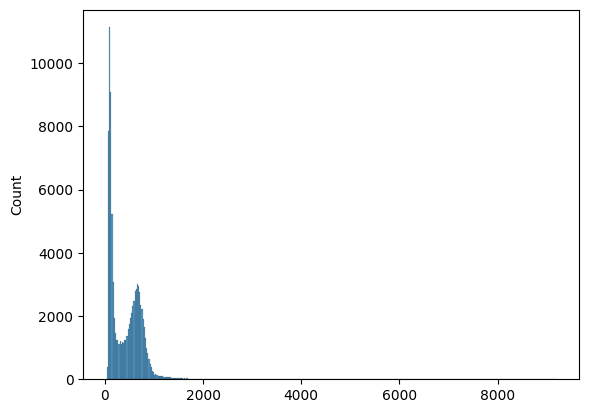

In [27]:
from tqdm.notebook import tqdm
import seaborn as sns

res3 = []
for x in tqdm(dataset['contents']):
    res3.append(len(tokenizer.encode(x)))

print(len([x for x in res3 if x>max_seq_length]))
sns.histplot(res3)

In [30]:
max_seq_length = 1024
print(len([x for x in res3 if x>max_seq_length]))


2327


In [12]:
# # 너무 긴 데이터는 잘못된 데이터일 가능성 크므로 제외!

# idxs = [i for i,x in enumerate(res3) if x>2500]
# print(len(idxs))

In [13]:
# dataset = dataset.filter(lambda x, i: i not in idxs, with_indices=True)
# dataset

### Continued Pretraining

In [26]:
import os
import requests

# 고정 설정
os.environ['WANDB_PROJECT']="krx"
os.environ['WANDB_API_KEY']="****"
os.environ['WANDB_ENTITY']="****"

# 개별 설정
os.environ['WANDB_TAGS']=""
run_name = ""

In [27]:
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from unsloth import UnslothTrainer, UnslothTrainingArguments

trainer = UnslothTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "contents",
    max_seq_length = max_seq_length,
    dataset_num_proc = 32,

    args = UnslothTrainingArguments(
        per_device_train_batch_size = 3,
        gradient_accumulation_steps = 8,

        # per_device_train_batch_size = 56,
        # gradient_accumulation_steps = 1,

        # Use warmup_ratio and num_train_epochs for longer runs!
        # max_steps = 120,
        # warmup_steps = 10,
        warmup_ratio = 0.06,
        num_train_epochs = 1,

        # Select a 2 to 10x smaller learning rate for the embedding matrices!
        learning_rate = 1e-5,
        embedding_learning_rate = 5e-6,

        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        # optim = "adamw_8bit", # "adamw_8bit",
        optim = "adamw_hf",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",  # "linear",
        seed = 777,
        output_dir = "outputs",
        save_strategy = "no",
        # save_strategy = "steps",
        # save_steps = 1000,
        # save_total_limit = 1,
        # report_to="none",
        report_to = "wandb",
        run_name = run_name,
    ),
)

Map (num_proc=32):   0%|          | 0/628467 [00:00<?, ? examples/s]

In [28]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA H100 80GB HBM3. Max memory = 79.109 GB.
14.689 GB of memory reserved.


In [ ]:
try:
    trainer_stats = trainer.train()
except Exception as e:
    print(e)
    

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
import wandb
# wandb 로깅 종료
wandb.finish()

## 모델 저장

In [ ]:
# for cpt

# Merged model 업로드
deploy_name = 'lsw0570168/krx-q25-7b-base-v7.2-fft'
model.push_to_hub_merged(deploy_name, tokenizer, save_method = "merged_16bit", token = hf_token) # 개인 huggingface token을 사용하여 업로드할 수 있습니다.


In [ ]:
# # LoRA Adapter 저장
# model.save_pretrained("lora_model")
# tokenizer.save_pretrained("lora_model")

In [13]:
# # Merged model 저장
# local_model_save_path = "e3"
# model.save_pretrained_merged(local_model_save_path, tokenizer, save_method = "merged_16bit",)

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 702.4 out of 1007.38 RAM for saving.


100%|██████████| 28/28 [00:00<00:00, 961.70it/s]

Unsloth: Saving tokenizer...

 Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Done.


## 모델 추론 테스트

In [24]:
FastLanguageModel.for_inference(model)
# model.eval()

qq = '''\
다음 문제를 읽고 정답으로 가장 알맞은 것을 고르시요.
### 질문: Pandas의 rolling 메서드를 사용하여 주가 데이터의 30일 변동성을 계산하려고 합니다. 다음 중 올바른 코드를 선택하세요.\n\n### df.head()\n| Date       | Close |\n|------------|-------|\n| 2023-01-01 | 150.0 |\n| 2023-01-02 | 152.0 |\n| 2023-01-03 | 155.0 |\n| 2023-01-04 | 158.0 |\n| 2023-01-05 | 160.0 |

### 선택지:
"A. df['Volatility'] = df['Close'].rolling(window=30).std()",
"B. df['Volatility'] = df['Close'].expanding().std()",
"C. df['Volatility'] = df['Close'].rolling(window=30).mean()",
"D. df['Volatility'] = df['Close'].rolling(window=30).var()",
"E. df['Volatility'] = df['Close'].std()
'''

inputs = tokenizer(
[
    qq,
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

다음 문제를 읽고 정답으로 가장 알맞은 것을 고르시요.
### 질문: Pandas의 rolling 메서드를 사용하여 주가 데이터의 30일 변동성을 계산하려고 합니다. 다음 중 올바른 코드를 선택하세요.

### df.head()
| Date       | Close |
|------------|-------|
| 2023-01-01 | 150.0 |
| 2023-01-02 | 152.0 |
| 2023-01-03 | 155.0 |
| 2023-01-04 | 158.0 |
| 2023-01-05 | 160.0 |

### 선택지:
"A. df['Volatility'] = df['Close'].rolling(window=30).std()",
"B. df['Volatility'] = df['Close'].expanding().std()",
"C. df['Volatility'] = df['Close'].rolling(window=30).mean()",
"D. df['Volatility'] = df['Close'].rolling(window=30).var()",
"E. df['Volatility'] = df['Close'].std()
### 정답: A.<|endoftext|>


In [25]:
qq = "일본의 2023년 6월 개정 자금결제법의 주요 변경 사항을 설명하고, 이러한 변경이 일본의 금융시장 및 국제 금융 규제에 미치는 영향을 논의하시오."

inputs = tokenizer(
[
    qq,
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

일본의 2023년 6월 개정 자금결제법의 주요 변경 사항을 설명하고, 이러한 변경이 일본의 금융시장 및 국제 금융 규제에 미치는 영향을 논의하시오.<|endoftext|>


In [ ]:
# del model
# torch.cuda.empty_cache()